<a href="https://colab.research.google.com/github/Sirabhop/Preclinical-AD-EEG-classification/blob/master/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
from oauth2client.service_account import ServiceAccountCredentials
from sklearn import preprocessing
from sklearn import preprocessing

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
import mne

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [255]:
os.chdir("/content/drive/My Drive/Colab Notebooks")
%run EEG_Feature_Extraction.ipynb

updated 26/4/2020, 14.30


In [0]:
#Set up google drive API
os.chdir("/content/drive/My Drive/EEG Data")
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scope)
client = gspread.authorize(creds)

# **Descriptive Statistics**

##**Demographics**

In [0]:
dict = {'sex': ['male', 'female', 'female', 'female', 'female', 'female', 'female', 'female'],
        'ages':[63, 60, 66, 68, 72, 74, 61, 64],
        'group': [0,1,1,0,1,1,0,0]} #0 = Risk Free, 1 = At risk

In [8]:
df = pd.DataFrame(data = dict)
df

,sex,ages,group
0,male,63,0
1,female,60,1
2,female,66,1
3,female,68,0
4,female,72,1
5,female,74,1
6,female,61,0
7,female,64,0


##**Cognitive Markers**


In [0]:
gsheet_MoCA = client.open("MoCA DATA").sheet1
gsheet_FCSRT = client.open("FCSRT DATA").sheet1
list_MoCA = gsheet_MoCA.get_all_records()
list_FCSRT = gsheet_FCSRT.get_all_records()

In [0]:
FCSRT = pd.DataFrame(list_FCSRT)
MoCA = pd.DataFrame(list_MoCA)

MoCA = pd.concat([df, MoCA], axis = 1).drop(['NAME','SEX','AGE'], axis = 1)
CogMarkers = pd.concat([df, FCSRT, MoCA[['SUM']]], axis = 1)
CogMarkers['group'] = CogMarkers['group'].astype('category')
CogMarkers.set_index('id', inplace = True)
CogMarkers.rename(columns = {'SUM':'MoCA'}, inplace = True)
#CogMarkers.to_csv('cognitive marker.csv')

###**FCSRT**

* **% Encoded**
  * SOMI 0: > 95.8%
  * SOMI 1: > 95.8%
  * SOMI 2a: > 95.8%
  * SOMI 2b: > 93.75 and < 95.8%
  * SOMI 4: > 68.78 and < 91.67%



In [0]:
#computed from [Total Recall x 100]/16
CogMarkers['%Encoded'] = ((CogMarkers['IR-FreeR']+CogMarkers['IR-CuedR'])*100)/16 

*   **% Retrieval**
  * SOMI 0: > 62.5%
  * SOMI 1: > 52.1% and < 62.5%
  * SOMI 2a: > 41.6% and < 50%
  * SOMI 2b: > 41.6% and < 50%
  * SOMI 4: Any


In [0]:
CogMarkers['%Retrieval'] =  CogMarkers['IR-FreeR']*100/16

*   **Classify SS according to SOMI model criteria**


In [0]:
for i in range(-1,7):
  if (CogMarkers.iloc[i, 8] > 95.8) & (CogMarkers.iloc[i, 9] > 62.5):
    CogMarkers['SOMI stage'] = 'SOMI 0'

  if (CogMarkers.iloc[i, 8] > 95.8):
    if (CogMarkers.iloc[i, 9] > 52.1) & (CogMarkers.iloc[i, 9] < 62.5):
      CogMarkers['SOMI stage'] = 'SOMI 1'

  if (CogMarkers.iloc[i, 8] > 95.8):
    if (CogMarkers.iloc[i, 9] > 41.6) & (CogMarkers.iloc[i, 9] < 50):
      CogMarkers['SOMI stage'] = 'SOMI 2a'

  if (CogMarkers.iloc[i, 8] > 93.75) & (CogMarkers.iloc[i, 8] < 95.8):
    if (CogMarkers.iloc[i, 9] > 41.6) & (CogMarkers.iloc[i, 9] < 50):
      CogMarkers['SOMI stage'] = 'SOMI 2b'

  if (CogMarkers.iloc[i, 8] > 68.78) & (CogMarkers.iloc[i, 8] < 91.67):
    if CogMarkers.iloc[i, 9] <= 41.6:
      CogMarkers['SOMI stage'] = 'SOMI 4'
  else:
    CogMarkers['SOMI stage'] = 'NaN'

In [0]:
Cog_Normal = CogMarkers[CogMarkers['group'] == 0]
Cog_Risk = CogMarkers[CogMarkers['group'] == 1]

In [0]:
per_cog_risk = Cog_Risk.copy()
per_cog_normal = Cog_Normal.copy()

In [0]:
per_cog_risk['IR-FreeR'] = (Cog_Risk['IR-FreeR']*100)/16
per_cog_risk['IR-CuedR'] = (Cog_Risk['IR-CuedR']*100)/(16-Cog_Risk['IR-FreeR'])
per_cog_risk['DL-FreeR'] = (Cog_Risk['DL-FreeR']*100)/16
per_cog_risk['DL-CuedR'] = (Cog_Risk['DL-CuedR']*100)/(16-Cog_Risk['DL-FreeR'])

per_cog_normal['IR-FreeR'] = (Cog_Normal['IR-FreeR']*100)/16
per_cog_normal['IR-CuedR'] = (Cog_Normal['IR-CuedR']*100)/(16-Cog_Normal['IR-FreeR'])
per_cog_normal['DL-FreeR'] = (Cog_Normal['DL-FreeR']*100)/16
per_cog_normal['DL-CuedR'] = (Cog_Normal['DL-CuedR']*100)/(16-Cog_Normal['DL-FreeR'])



*   **Graph**



In [0]:
def create_plot_df(Normal, Risk):
  plot_risk = Risk.drop(['sex', 'ages', 'group', 'MoCA', '%Encoded', '%Retrieval',	'SOMI stage'], axis =1)
  plot_risk = plot_risk.transpose()
  plot_risk = plot_risk.reset_index()
  plot_risk['mean'] = plot_risk.mean(axis = 1)

  plot_normal = Normal.drop(['sex', 'ages', 'group', 'MoCA', '%Encoded', '%Retrieval',	'SOMI stage'], axis =1)
  plot_normal = plot_normal.transpose()
  plot_normal = plot_normal.reset_index()
  plot_normal['mean'] = plot_normal.mean(axis = 1)

  return plot_normal, plot_risk

In [0]:
def plot_markers(plot_data, xlab, ylab, title):
  columns_risk = plot_data.drop(['index', 'mean'], axis = 1)
  title = title

  fig, ax = plt.subplots()
  for subjects in columns_risk:
      ax.plot(plot_data['index'], plot_data[subjects])
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')

  return ax.plot()

In [0]:
def plot_mean_markers(plot_normal, plot_risk, xlab, ylab, title):
  title = title

  fig, ax = plt.subplots()
  ax.plot(plot_risk['index'], plot_risk['mean'], label = 'Risk group')
  ax.plot(plot_normal['index'], plot_normal['mean'], label = 'Normal group')
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.legend()
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')
  return ax.plot()

[]

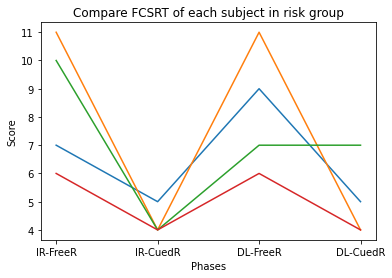

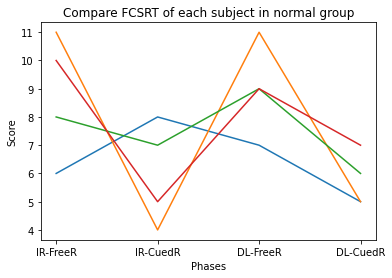

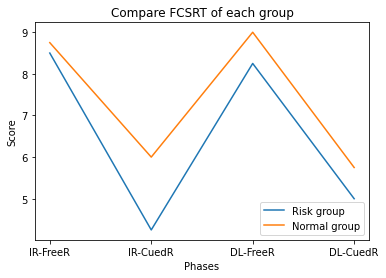

In [27]:
plot_cog_normal, plot_cog_risk = create_plot_df(Cog_Normal, Cog_Risk)
plot_markers(plot_cog_risk, 'Phases', 'Score', 'Compare FCSRT of each subject in risk group')
plot_markers(plot_cog_normal, 'Phases', 'Score', 'Compare FCSRT of each subject in normal group')
plot_mean_markers(plot_cog_normal, plot_cog_risk, 'Phases', 'Score', 'Compare FCSRT of each group')

[]

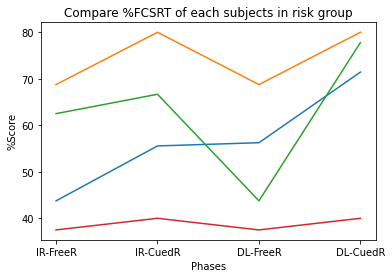

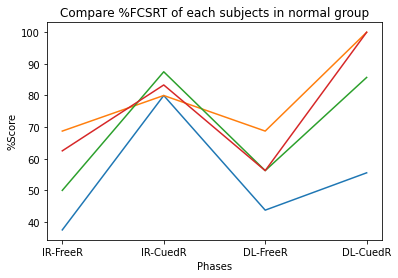

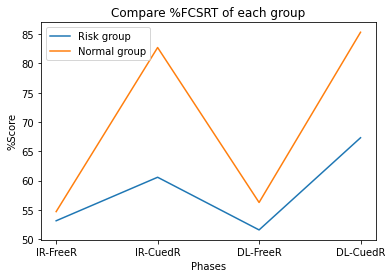

In [28]:
plot_cog_normal, plot_cog_risk = create_plot_df(per_cog_normal, per_cog_risk)
plot_markers(plot_cog_risk, 'Phases', '%Score', 'Compare %FCSRT of each subjects in risk group')
plot_markers(plot_cog_normal, 'Phases', '%Score', 'Compare %FCSRT of each subjects in normal group')
plot_mean_markers(plot_cog_normal, plot_cog_risk, 'Phases', '%Score', 'Compare %FCSRT of each group')

### **MoCA**



In [0]:
MoCA_RiskFree = MoCA[MoCA['group'] == 0]
MoCA_Risk = MoCA[MoCA['group'] == 1]

##**Biomarkers**

In [29]:
features = pd.read_csv('EEG_features.csv')
features.drop(['Unnamed: 0'], inplace = True, axis = 1)
Biomarkers = pd.concat([df, features], axis = 1)
Biomarkers.set_index('id', inplace = True)

Biomarkers

,sex,ages,group,PSD_Delta,PSD_Theta,PSD_Alpha,PSD_Beta,PSD_Gamma,MSF,SE,AC,wSMI_Alpha,wSMI_Theta
id,,,,,,,,,,,,,
SS1,male,63,0,8.191509e-14,6.892579e-13,6.892579e-13,2.206398e-13,9.171605e-14,1.674815e-13,2.513122,0.047027,0.069328,0.034951
SS2,female,60,1,1.159327e-13,9.541812e-13,9.541812e-13,5.450232e-13,1.249077e-13,2.717361e-13,2.476574,0.052528,0.065172,0.032267
SS3,female,66,1,9.004434e-14,7.554926e-13,7.554926e-13,5.202362e-13,5.302625e-13,4.418246e-13,2.483961,0.064709,0.060440,0.028957
SS4,female,68,0,9.099951e-14,1.023456e-12,1.023456e-12,4.707961e-13,2.931868e-13,3.786596e-13,2.476574,0.051643,0.051035,0.026086
SS5,female,72,1,1.059632e-13,9.294080e-13,9.294080e-13,5.621714e-13,1.519682e-13,2.856214e-13,2.407455,0.059398,0.065278,0.031481
SS6,female,74,1,5.203354e-14,4.367775e-13,4.367775e-13,1.945097e-13,9.020467e-14,1.481936e-13,2.407455,0.054304,0.067014,0.032455
SS7,female,61,0,1.679208e-13,1.454488e-12,1.454488e-12,8.374338e-13,5.455973e-13,6.437365e-13,2.492098,0.055813,0.064430,0.031130
SS8,female,64,0,6.228747e-14,5.084000e-13,5.084000e-13,3.189277e-13,2.124069e-13,2.546724e-13,2.407455,0.065214,0.063654,0.031456


###**PSD**

In [0]:
#Import Data
risk = ['SS2','SS5','SS6']
normal = ['SS4', 'SS7', 'SS8']

IR_psd_risk = get_psd_sorce(risk, 'IR')
DL_psd_risk = get_psd_sorce(risk, 'DL')

IR_psd_normal = get_psd_sorce(normal, 'IR')
DL_psd_normal = get_psd_sorce(normal, 'DL')

IR_psd_risk.to_csv('/content/drive/My Drive/EEG Data/IR_psd_risk.csv')
IR_psd_normal.to_csv('/content/drive/My Drive/EEG Data/IR_psd_normal.csv')

DL_psd_risk.to_csv('/content/drive/My Drive/EEG Data/DL_psd_risk.csv')
DL_psd_normal.to_csv('/content/drive/My Drive/EEG Data/DL_psd_normal.csv')

####**PSD before exclude bad channels**

In [0]:
def get_plot_df(psd_normal, psd_risk):
  #Import data
  psd_normal = pd.read_csv('psd_normal.csv').drop(['Unnamed: 0'],axis=1)#, 'PO3', 'O1','Fp1', 'AF3', 'Fp2','Fz'], axis = 1) #PO3, O1
  psd_normal['bands'] = ['delta', 'theta', 'alpha', 'beta', 'gamma']
  psd_normal.set_index('bands', inplace = True)

  psd_risk = pd.read_csv('psd_risk.csv').drop(['Unnamed: 0'],axis=1)#, 'PO3', 'O1', 'Fp1', 'AF3', 'Fp2','Fz'], axis = 1) #Fp1, AF3, Fp2, Fz
  psd_risk['bands'] = ['delta', 'theta', 'alpha', 'beta', 'gamma']
  psd_risk.set_index('bands', inplace = True)

  #Transpose
  plot_normal = psd_normal.transpose().reset_index()
  plot_risk = psd_risk.transpose().reset_index()

  #Delete index
  index = plot_normal['index']
  plot_normal.drop(['index'], inplace = True, axis = 1)
  plot_risk.drop(['index'], inplace = True, axis = 1)

  #Scaling by freq band
  scaler_n = preprocessing.MinMaxScaler()
  plot_normal[plot_normal.columns] = scaler_n.fit_transform(plot_normal[plot_normal.columns])

  scaler_r = preprocessing.MinMaxScaler()
  plot_risk[plot_risk.columns] = scaler_r.fit_transform(plot_risk[plot_risk.columns])

  #Prepare dataset 
  plot_normal = pd.concat((index, plot_normal), axis = 1)
  plot_risk = pd.concat((index, plot_risk), axis = 1)
  
  return plot_normal, plot_risk

In [0]:
IR_plot_normal, IR_plot_risk = get_plot_df(IR_psd_normal, IR_psd_risk)
DL_plot_normal, DL_plot_risk = get_plot_df(DL_psd_normal, DL_psd_risk)

In [0]:
#Plot
def plot_compare_psd(plot_normal, plot_risk, title):
  title = title
  fig = plt.figure(figsize=(40,20))
  for i in range(len(bands)):
      fig.add_subplot(3, 2, i+1)
      plt.plot(plot_risk['index'], plot_risk.iloc[:,i+1], label = 'Risk group', color = 'red')
      plt.plot(plot_normal['index'], plot_normal.iloc[:,i+1], label = 'Normal group', color = 'green')
      plt.title(plot_normal.columns[i+1]+' band')
      plt.xlabel('Channel')
      plt.ylabel('PSD (db)')
      plt.legend()
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/Biomarkers/'+title+'.png')
  return plt.show()

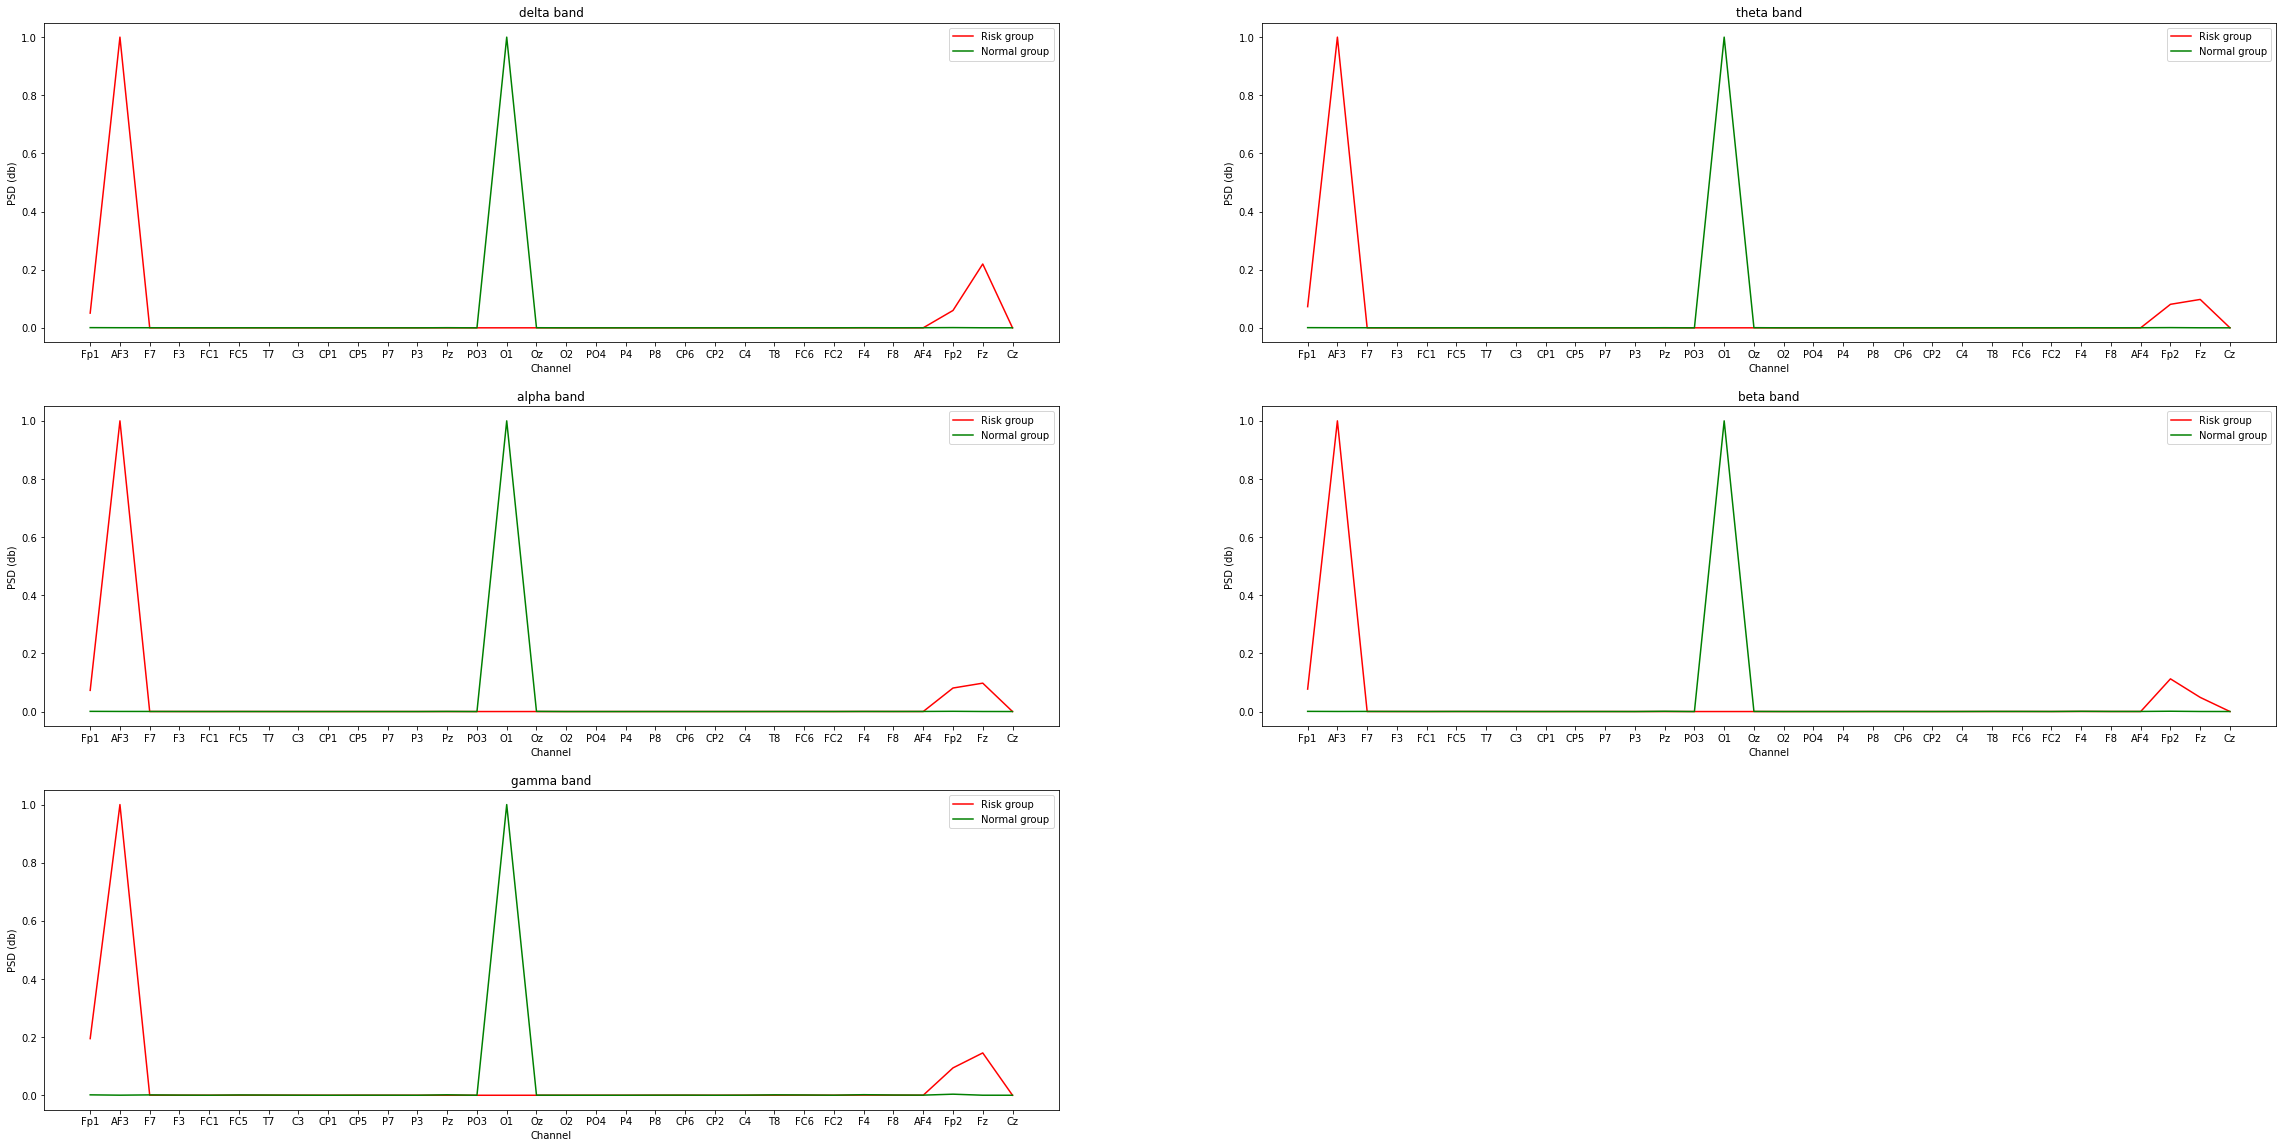

In [235]:
plot_compare_psd(IR_plot_normal, IR_plot_risk, 'compare PSD IR')

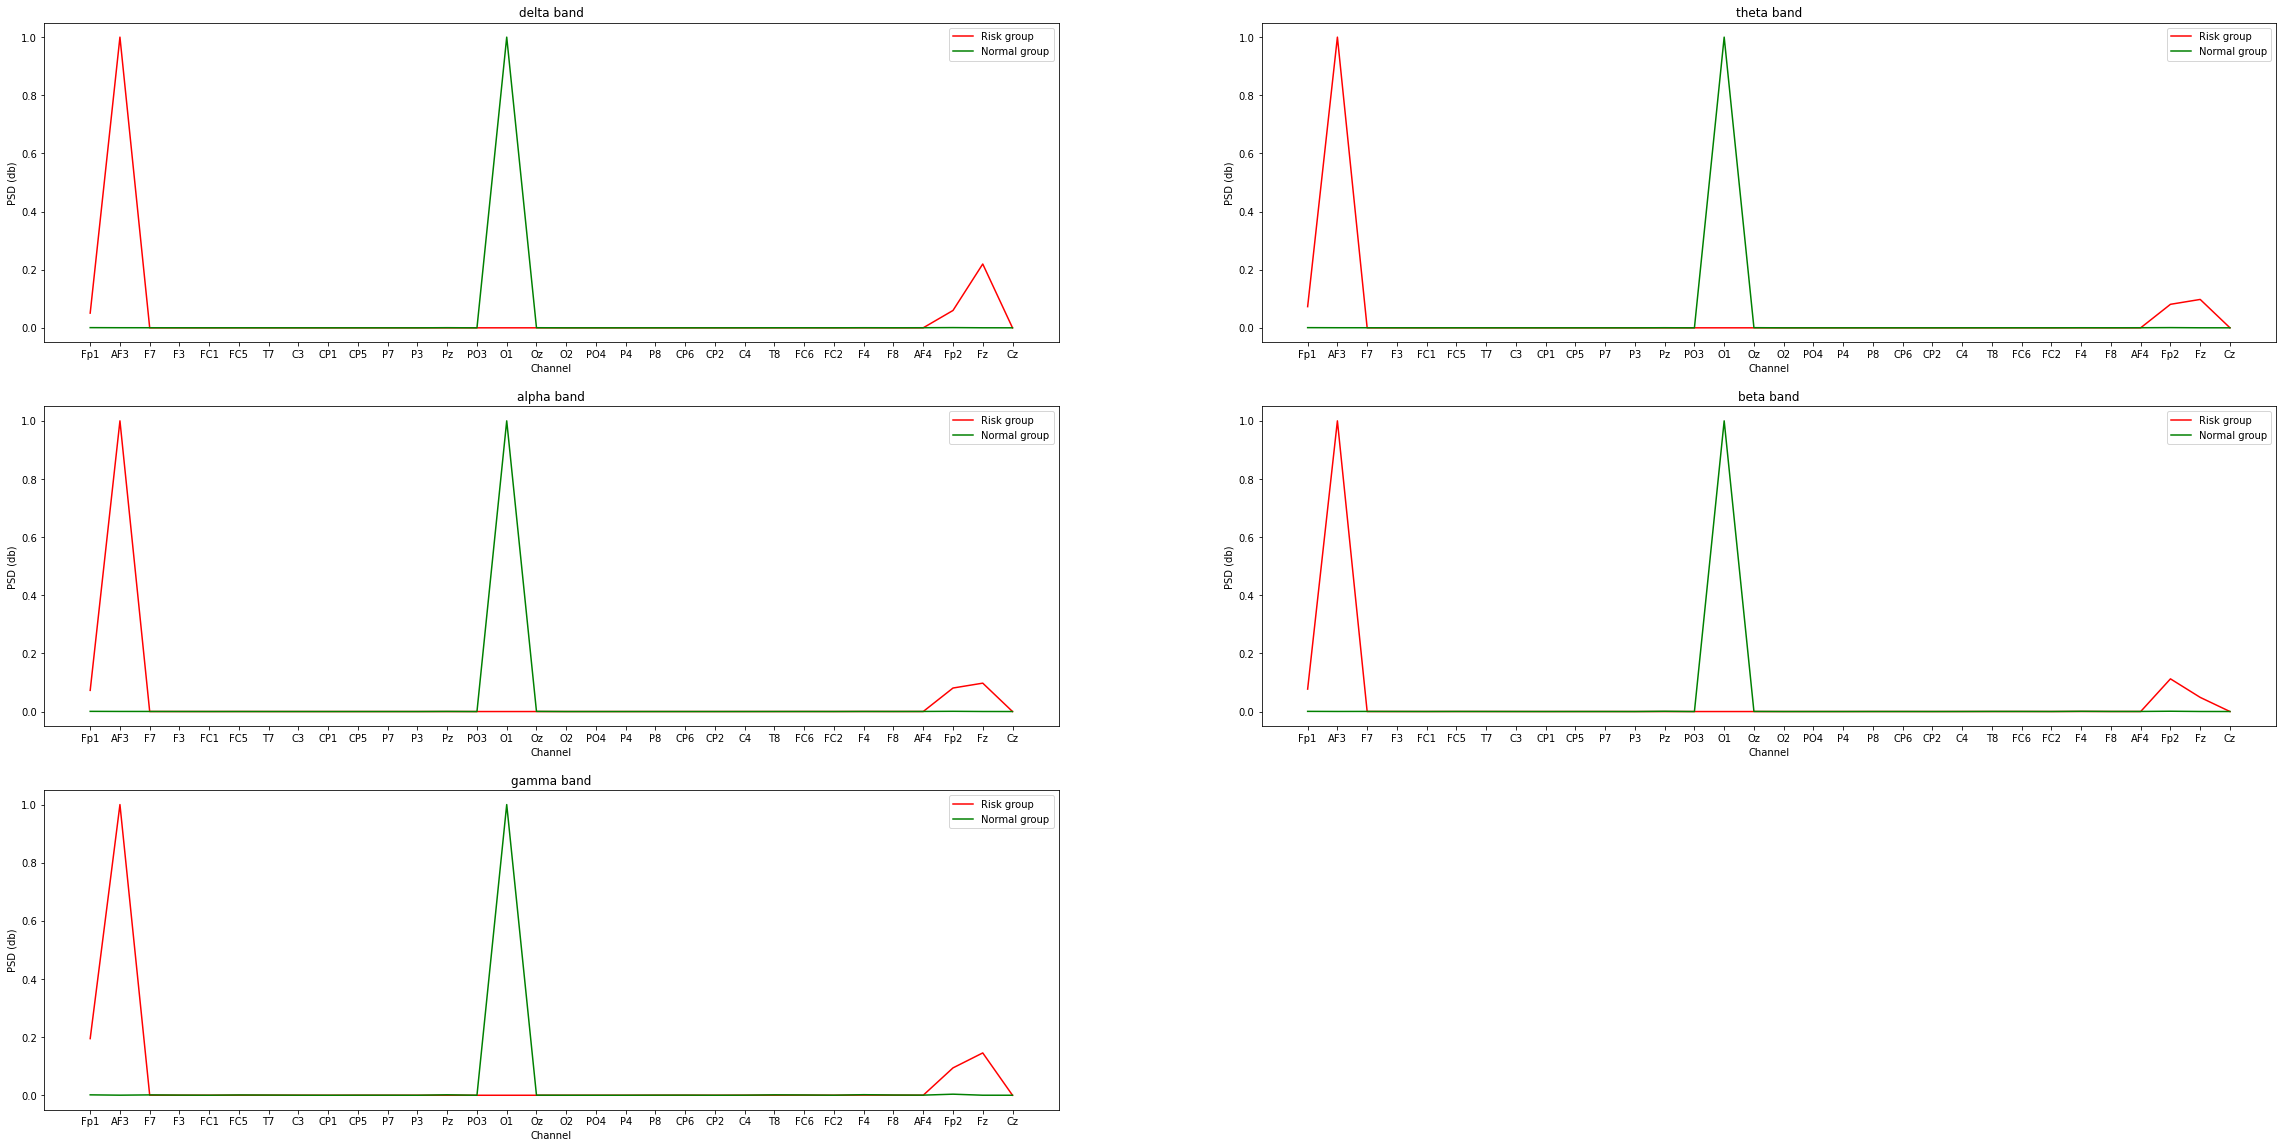

In [236]:
plot_compare_psd(DL_plot_normal, DL_plot_risk, 'compare PSD IR')

####**Plot mean PSD of each band**

Immediate Phase

In [0]:
#Duplicate data
plot_normal_IR = IR_plot_normal.copy()
plot_risk_IR = IR_plot_risk.copy()

col = plot_normal_IR.iloc[:,0]

#Transpose
plot_normal_IR = plot_normal_IR.transpose()
plot_risk_IR = plot_risk_IR.transpose()

#Add columns
plot_normal_IR.columns = col
plot_risk_IR.columns = col

#Drop index
plot_normal_IR.drop('index', axis = 0, inplace = True)
plot_risk_IR.drop('index', axis = 0, inplace = True)

Delay phase

In [0]:
#Duplicate data
plot_normal_DL = DL_plot_normal.copy()
plot_risk_DL = DL_plot_risk.copy()

col = plot_normal_DL.iloc[:,0]

#Transpose
plot_normal_DL = plot_normal_DL.transpose()
plot_risk_DL = plot_risk_DL.transpose()

#Add columns
plot_normal_DL.columns = col
plot_risk_DL.columns = col

#Drop index
plot_normal_DL.drop('index', axis = 0, inplace = True)
plot_risk_DL.drop('index', axis = 0, inplace = True)

**Select frontocentral area**

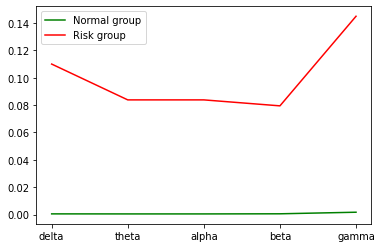

In [244]:
plt.plot(plot_normal_b[['Fp1', 'Fp2', 'Fz']].mean(axis = 1), label = 'Normal group', color = 'green')
plt.plot(plot_risk_b[['Fp1', 'Fp2', 'Fz']].mean(axis = 1), label = 'Risk group', color = 'red')
plt.legend()
plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/Biomarkers/Compare PSD of Fp1,Fp2,Fz each group in IR phase.png')

**Overall area**

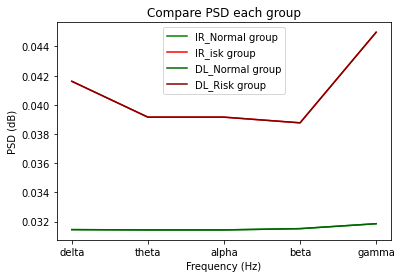

In [249]:
plt.plot(plot_normal_IR.mean(axis = 1), label = 'IR_Normal group', color = 'green')
plt.plot(plot_risk_IR.mean(axis = 1), label = 'IR_isk group', color = 'red')

plt.plot(plot_normal_DL.mean(axis = 1), label = 'DL_Normal group', color = 'darkgreen')
plt.plot(plot_risk_DL.mean(axis = 1), label = 'DL_Risk group', color = 'maroon')

plt.ylabel('PSD (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('Compare PSD each group')
plt.legend()
plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/Biomarkers/Compare PSD each group in IR phase.png')

# **Inferencial Statistics**

####**Cognitive Markers**

In [0]:
import scipy
import matplotlib.pyplot as plt

* 1-way ANOVA (Risk vs Free Risk)



In [0]:
#Encoding
print(scipy.stats.f_oneway(Cog_Risk['IR-CuedR'], Cog_RiskFree['IR-CuedR'])) #sig

#Retrieval
print(scipy.stats.f_oneway(Cog_Risk['IR-FreeR'], Cog_RiskFree['IR-FreeR'])) #sig

F_onewayResult(statistic=3.4186046511627906, pvalue=0.11395633124158694)
F_onewayResult(statistic=0.023622047244094488, pvalue=0.8828895569688998)


In [0]:
CogMarkers2 = CogMarkers
CogMarkers2['group'][CogMarkers2['group'] == 0] = 'Normal'
CogMarkers2['group'][CogMarkers2['group'] == 1] = 'Risk'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
CogMarkers2

,sex,ages,group,IR-FreeR,IR-CuedR,DL-FreeR,DL-CuedR,MoCA
0,male,63,Normal,6,8,7,5,21
1,female,60,Risk,7,5,9,5,7
2,female,66,Risk,11,4,11,4,9
3,female,68,Normal,11,4,11,5,22
4,female,72,Risk,10,4,7,7,12
5,female,74,Risk,6,4,6,4,15
6,female,61,Normal,8,7,9,6,20
7,female,64,Normal,10,5,9,7,6


No handles with labels found to put in legend.


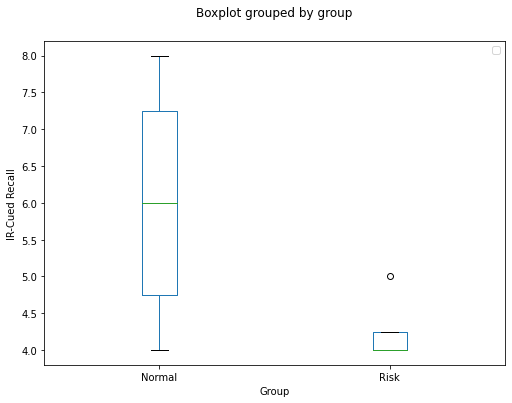

In [0]:
CogMarkers2.boxplot(column = ['IR-CuedR'], by = ['group'], grid = False, figsize = (8,6))
plt.title(None)
plt.xlabel('Group')
plt.ylabel('IR-Cued Recall')
plt.legend()
plt.show()

####**Biomarkers**